# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [2]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import sqlite3

In [3]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4.1-mini"
openai = OpenAI()

DB = "prices.db"

OpenAI API Key exists and begins sk-proj-


In [4]:
system_message = """
You are a helpful assistant for an Airline called FlightAI.
Give short, courteous answers, no more than 1 sentence.
Always be accurate. If you don't know the answer, say so.
"""

In [5]:
def get_ticket_price(city):
    print(f"DATABASE TOOL CALLED: Getting price for {city}", flush=True)
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('SELECT price FROM prices WHERE city = ?', (city.lower(),))
        result = cursor.fetchone()
        return f"Ticket price to {city} is ${result[0]}" if result else "No price data available for this city"

In [6]:
get_ticket_price("Paris")

DATABASE TOOL CALLED: Getting price for Paris


'Ticket price to Paris is $899.0'

In [7]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}
tools = [{"type": "function", "function": price_function}]
tools

[{'type': 'function',
  'function': {'name': 'get_ticket_price',
   'description': 'Get the price of a return ticket to the destination city.',
   'parameters': {'type': 'object',
    'properties': {'destination_city': {'type': 'string',
      'description': 'The city that the customer wants to travel to'}},
    'required': ['destination_city'],
    'additionalProperties': False}}}]

In [8]:

def chat(message, history):
    history = [{"role": h["role"], "content": h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat).launch()

Running on local URL:  http://127.0.0.1:7883

To create a public link, set `share=True` in `launch()`.


In [9]:
def chat(message, history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses = handle_tool_calls(message)
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    
    return response.choices[0].message.content

In [10]:
def handle_tool_calls(message):
    responses = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses

In [ ]:
gr.ChatInterface(fn=chat).launch()

Running on local URL:  http://127.0.0.1:7884

To create a public link, set `share=True` in `launch()`.


DATABASE TOOL CALLED: Getting price for London
DATABASE TOOL CALLED: Getting price for London


In [12]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [13]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

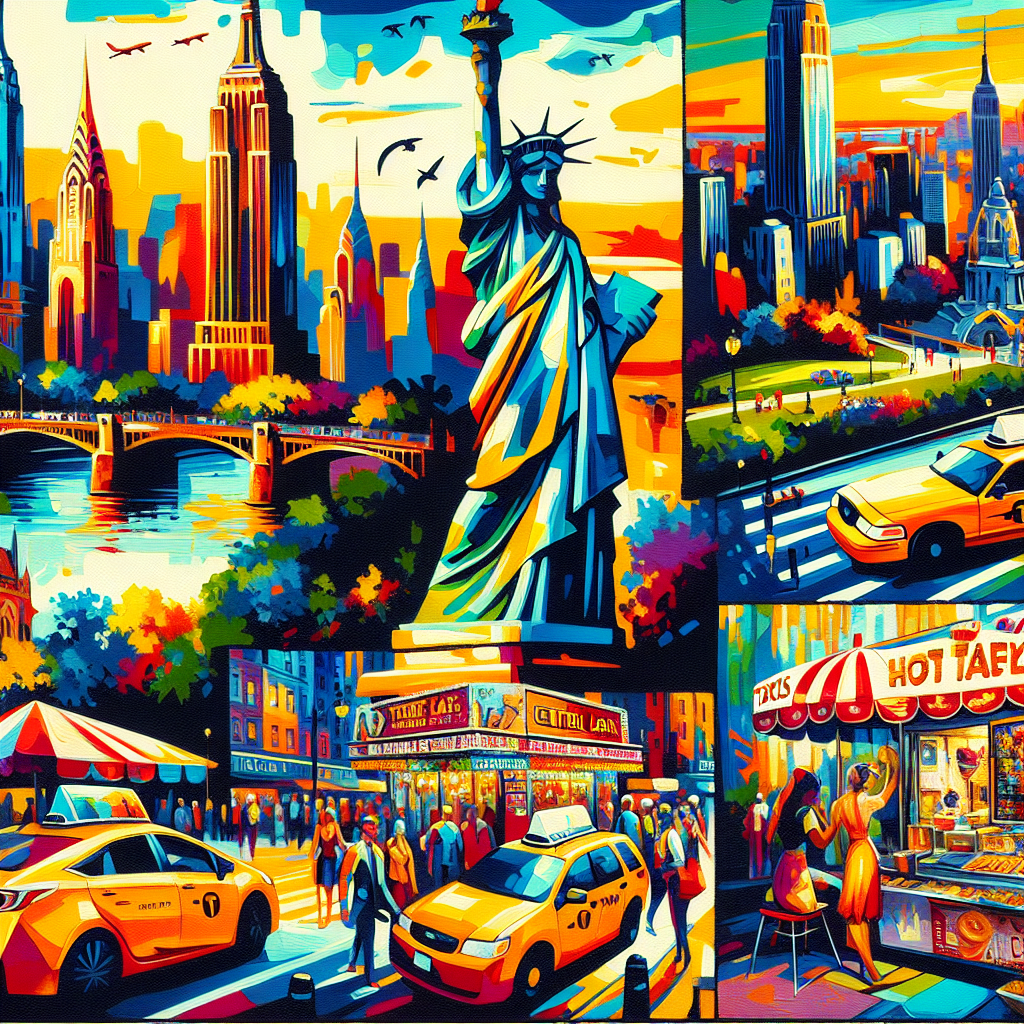

In [14]:
image = artist("New York City")
display(image)